## Build an MNIST model

### Setup

In [1]:
import logging
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


### Train a Tensorflow model

In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images/255.
test_images = test_images/255.

# Define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (28, 28)),
    keras.layers.Reshape(target_shape = (28, 28, 1)),
    keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), activation = tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.fit(
    train_images,
    train_labels,
    epochs = 1,
    validation_data = (test_images, test_labels)
)

1875/1875 [==============================] - 27s 14ms/step - loss: 0.2845 - accuracy: 0.9180 - val_loss: 0.1426 - val_accuracy: 0.9591


### Convert to a Tensorflow Lite model

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpecgu4294/assets


Write it out to a tfile file:

In [4]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models")
tflite_models_dir.mkdir(exist_ok = True, parents = True)

In [5]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

To quantize the model on export, set the `optimizations` flag to optimize for size:

In [6]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpvo3qfd4d/assets


24064

In [9]:
!ls -lh {tflite_models_dir}

total 108K
-rw-r--r-- 1 root root 24K Apr 10 18:09 mnist_model_quant.tflite
-rw-r--r-- 1 root root 83K Apr 10 18:06 mnist_model.tflite


## Run the TFLite models

### Load the model into an interpreter

In [10]:
interpreter = tf.lite.Interpreter(model_path = str(tflite_model_file))
interpreter.allocate_tensors()

In [12]:
interpreter_quant = tf.lite.Interpreter(model_path = str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

### Test the model on one image

In [14]:
test_image = np.expand_dims(test_images[0], axis = 0).astype(np.float32)

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

print(input_index)
print(output_index)
interpreter.get_input_details()

0
17


[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([-1, 28, 28], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [15]:
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
predictions

array([[ -3.7705522, -11.956098 ,  -3.1097705,   1.2252074,  -7.302723 ,
         -4.470283 , -14.491849 ,   8.498953 ,  -4.7523227,  -0.9910742]],
      dtype=float32)

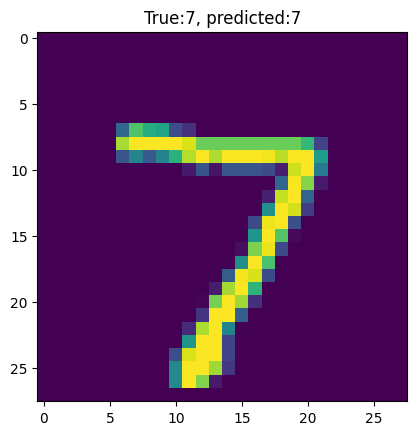

In [16]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [19]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [20]:
print(evaluate_model(interpreter))

0.9591


In [21]:
print(evaluate_model(interpreter_quant))

0.9589
